In [29]:
import os
import cooler
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan

def check_cooler_fp(fp):
    
    ft = fp.split('.')[-1]
    assert ft in ['cool','mcool'], f'The Cooler filepath must end in .mcool or .cool. Received .{ft}'

    if os.path.exists(fp): 
        return fp, ft

    # If here, then the passed file cannot be found. 
    # Check if the file exists with the alternative Cooler type. 
    file_root = fp[:-len(ft)-1]
    alt_ft = 'cool' if ft=='mcool' else 'mcool' 
    alt_fp = file_root + '.' + alt_ft
    assert os.path.exists(alt_fp), 'The specified cooler filepath does not exist.'

    # If here, then the alternative filepath DOES exist
    return alt_fp, alt_ft

def get_Cooler(fp,resolution):

    fp,_ = check_cooler_fp(fp) 

    while True:

        if cooler.fileops.is_cooler(fp): 
            # Single resolution cooler file 
            clr = cooler.Cooler(fp)
            res = clr.info['bin-size']
            if res != resolution: 
                # Check if alternative path exists with multiple resolutions
                fp2 = fp[:-4] + 'mcool' 
                if os.path.exists(fp2) and cooler.fileops.is_multires_file(fp2):
                    fp = fp2 # We'll want to load from the multires file/not overwrite it with less data 
                    continue 
            
            resolutions = [res] 
            
        else: 
            # Multires file 
            assert cooler.fileops.is_multires_file(fp), 'The provided filepath does not correspond to a cooler file!'
            
            resolutions = [int(c.split('/')[-1]) for c in cooler.fileops.list_coolers(fp)]
            if resolution in resolutions: 
                clr = cooler.Cooler(fp+f'::/resolutions/{resolution}')
                res = resolution
            else: 
                res = -1
            
        if res == resolution: 
            return fp, clr 
        print("The desired resolution isn't available in the provided file. Coarsening the data to obtain contact data at the desired resolution.",flush=True)
        print("This might take a while...",flush=True)
        
        # Coarsen the data to the desired resolution. 
        fp_new = fp if fp[-5:] == 'mcool' else fp[:-4] + 'mcool' 
        cooler.zoomify_cooler( # ONLY WORKS IF GIVEN SPECIFIC URI 
            fp,
            fp_new,
            resolutions=resolutions.append(resolution),
            chunksize=1000000
        )
        fp = fp_new 

import torch
import copy 
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cooltools.lib.plotting # provides 'fall' colormap

def add_diagonal(mat): 

    # Initialize the new matrix
    n = mat.shape[0] + 1
    mat1 = torch.empty(n,n,dtype=mat.dtype,device=mat.device)

    # Fill in the upper/lower matrices
    i,j = torch.triu_indices(n,n,1)
    j2 = j - 1
    mat1[i,j] = mat[i,j2] 
    mat1[j,i] = mat[j2,i] 

    # Fill in the diagonal with ones (assume self-interaction probability==1, essentially) 
    mat1.fill_diagonal_(1)

    return mat1 

def pcc(mat1,mat2,ignore_diagonal=True,lower=False): 
    assert mat1.shape==mat2.shape

    n = mat1.shape[0] 
    i,j = torch.triu_indices(n,n,int(ignore_diagonal))
    if lower: 
        i,j = j,i

    mat = torch.stack((mat1[i,j],mat2[i,j]),dim=0)

    return torch.corrcoef(mat)[0,1] 

class HiCMap: 
    '''
    hic class that can be obtained from either the Sample class or the Hi-C dataset class
    Should have attributes for easy comparison, e.g. hic_map1.pcc(hic_map2) 
    Should also have a plot function 
    '''
    def __init__(
        self,
        prob_map,
        *,
        chrom=None,
        start=None,
        stop=None,
        includes_self_interaction=True,
        device='cuda' if torch.cuda.is_available() else None, #None,
        dtype=torch.double
    ):

        # Ensure probability map is a torch Tensor
        if type(prob_map) == np.ndarray: 
            prob_map = torch.from_numpy(prob_map)

        # Ensure the probability map is square. Remove any dimensions of 1
        p = prob_map.squeeze()
        assert len(p.shape) == 2, f'The provided probability map should have exactly two nonsingleton dimensions, but has dimensions {prob_map.shape}'
        assert prob_map.shape[0]==prob_map.shape[1], f'The provided probability map should be square, but has dimensions {prob_map.shape}'
        prob_map = p 

        # Satisfy device requirements & dtype requirements
        #if device is None: 
        #    # By default, use the GPU (if available) 
        #    device = 'cuda' if torch.cuda.is_available() else None
        self.prob_map = prob_map.to(device=device,dtype=dtype)

        # If the diagonal is not included, add it
        if not includes_self_interaction: 
            self.prob_map = add_diagonal(self.prob_map)

        # Set the properties of the given region. 
        # **** not used for now, but should be used in self.plot later for label/tick generation ****
        self.chrom = chrom
        self.start = start
        self.stop = stop 
        
    #####################################################
    # Basic properties & functionality 
    @property
    def device(self):
        return self.prob_map.device

    @property
    def dtype(self):
        return self.prob_map.dtype

    @property
    def shape(self):
        return self.prob_map.shape

    @property
    def nbins(self): 
        return self.shape[0] 

    def __getitem__(self,*args): 
        return self.prob_map[args]

    def clone(self):
        # Return a deep copy of the object
        return copy.deepcopy(self) 

    def to_(self,*args):
        # In-place
        self.prob_map = self.prob_map.to(*args)

    def to(self,*args):
        # Returns copy with desired attributes
        out = self.clone()
        out.to_(*args)
        return out

    #####################################################
    # Operations
    def pcc(self,hic_map,*args):
        # Pearson correlation coefficient
        if type(hic_map) in [torch.Tensor, np.ndarray]: 
            # This will ensure the matrix is square, etc etc
            hic_map = HiCMap(hic_map)
    
        assert type(hic_map) == type(self), f"The hic_map argument should be of type {type(self)}, torch.Tensor, or np.ndarray. Received {type(hic_map)}"

        if hic_map.dtype != self.dtype or hic_map.device != self.device: 
            hic_map = hic_map.to(device=self.device,dtype=self.dtype) 

        return pcc(self.hic_map,hic_map,*args)

    #####################################################
    # Visualization 
    def plot(
        self,
        *,
        vmin=None,
        vmax=1,
        cmap='fall',
        #title=None, # Add functionality for these later. 
        #colorbar_label=None,
        #xlabel=None,
        #ylabel=None
    ):

        norm = LogNorm(vmin=vmin,vmax=vmax)
        n,hic_map = self.nbins, self.prob_map
        extent = (0,n,n,0)
        
        fig = plt.figure()
        ax = fig.add_subplot(111) 
        
        im = ax.matshow(
            hic_map.cpu().numpy(),
            norm=norm,
            cmap=cmap,
            extent=extent
        );
        ax.xaxis.set_visible(False)
        
        cbar = fig.colorbar(im, label='Interaction Frequencies',location='right');
    
        return fig,ax,im,cbar

class HiCDataset:

    def __init__(
        self,
        cooler_fp='../../data/outside/GM12878_hg19.mcool',
        resolution=20000,
    ):

        self.cooler_fp, self.clr = get_Cooler(cooler_fp,resolution)
        self.resolution = resolution

    @property
    def chroms(self):
        return self.clr.bins()[:]['chrom'].unique()

    def fetch(
        self,
        chrom=None,
        start=None,
        stop=None,
        balance=True,
        adaptive_coarsegraining=False, # At least for cooltools <= 0.6.1, this does not work 
                                       # with NumPy >= 24 because np.int was removed. Either load
                                       # with older NumPy version or check if more recent cooltools version has been released. 
                                       # As of 1/5/2023, the relevant bug is located at line 1318 of cooltools/cooltools/lib/numutils.py: 
                                       # https://github.com/open2c/cooltools/blob/8af2b1087f7302d282dc77a82047ac0a3a8339c1/cooltools/lib/numutils.py#L1318C1-L1319C1
        adaptive_coarsegraining_cutoff=3,
        adaptive_coarsegraining_max_levels=8,
        interp_nan=False
    ):
        '''
        Should take the 
        '''
        clr = self.clr

        ''' # Need to convert the mcool file's chromosome definitions from '1', '2', ... to 'chr1', ...
        if type(chrom) == int: 
            chrom = f'chr{chrom}'
        elif type(chrom) == str:
            if (len(chrom) <= 3) or (chrom[:3] != 'chr'):
                chrom = f'chr{chrom}'
        else: 
            raise Exception('invalid chrom identifier')
        '''

        if chrom is None: 
            region = ''
        else: 
            region = str(chrom)
            if start is not None or stop is not None: 
                region+= ':'
                region+= '0' if start is None else str(start)
                region+= '-'
                region+= '' if stop is None else str(stop)
        
        #region = f'{chrom}:{start}-{stop}'

        if adaptive_coarsegraining: 
            mat = adaptive_coarsegrain(
                clr.matrix(balance=True).fetch(region),
                clr.matrix(balance=False).fetch(region),
                cutoff=adaptive_coarsegraining_cutoff, 
                max_levels=adaptive_coarsegraining_max_levels
            )
        else: 
            mat = clr.matrix(balance=balance).fetch(region)

        if interp_nan: 
            mat = interp_nan(cg)

        return HiCMap(
            mat, 
            chrom=chrom,
            start=start,
            stop=stop,
            includes_self_interaction=True,
        )

        #return mat
        #return HiCMap(mat) # Once class is written
            


In [1]:
import sys
sys.path.insert(1,'../data_utils')
from HiCMap import HiCMap
from HiCDataset import HiCDataset

In [2]:
exp_hic = HiCDataset()
chrom='1'
start=1_000_000
stop=10_000_000

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f9701e66da0>)

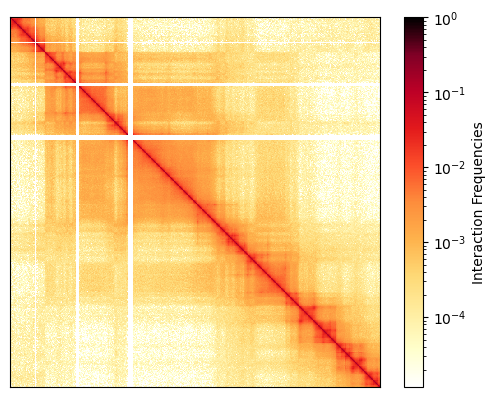

In [3]:
map = exp_hic.fetch(chrom,start,stop)
map.plot()

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f96ffb5e7a0>)

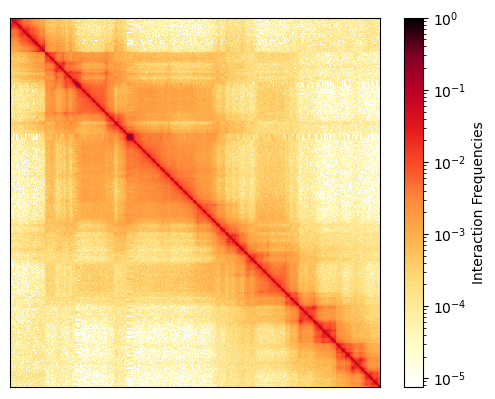

In [4]:
map = exp_hic.fetch(chrom,start,stop,interp_nans=True)
map.plot()

In [10]:
shift = 1_000_000
map = exp_hic.fetch(chrom,start,stop,interp_nans=True)
map2 = exp_hic.fetch(chrom,start+shift,stop+shift,interp_nans=True)
map.pcc(map2)

tensor(0.6328, dtype=torch.float64)

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f96ffcdfee0>)

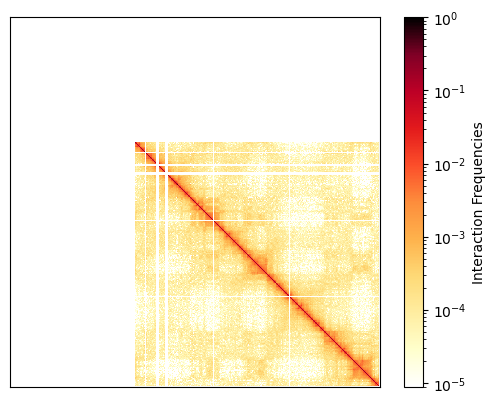

In [6]:
map = exp_hic.fetch(chrom=22)#,stop=20000*1250)
map.plot()

In [8]:
import torch
class Test: 

    def __init__(self,*args): 
        self.val = torch.rand(*args)

    def __getitem__(self,i):
        return self.val[i]

In [9]:
t = Test(100,100)
t[0,:]

tensor([0.0064, 0.4146, 0.4606, 0.6369, 0.5600, 0.8799, 0.6847, 0.8500, 0.9437,
        0.6417, 0.4787, 0.4010, 0.4186, 0.6710, 0.8740, 0.0339, 0.7030, 0.7794,
        0.2419, 0.7772, 0.0487, 0.8049, 0.0323, 0.8823, 0.9942, 0.8598, 0.4558,
        0.5034, 0.8091, 0.2101, 0.4891, 0.0800, 0.1605, 0.1820, 0.6414, 0.4318,
        0.8495, 0.9304, 0.9541, 0.6991, 0.7128, 0.1577, 0.1166, 0.0156, 0.1107,
        0.2819, 0.1768, 0.7582, 0.4715, 0.6680, 0.9303, 0.0070, 0.6502, 0.1494,
        0.0908, 0.7314, 0.7552, 0.9743, 0.8082, 0.8515, 0.9452, 0.9126, 0.8771,
        0.2416, 0.8917, 0.1322, 0.8921, 0.6881, 0.5382, 0.6264, 0.3523, 0.1538,
        0.7408, 0.8007, 0.9201, 0.0179, 0.1428, 0.5947, 0.3703, 0.2337, 0.5431,
        0.1551, 0.0650, 0.5285, 0.0765, 0.1816, 0.2925, 0.0953, 0.7156, 0.0774,
        0.4528, 0.0468, 0.4386, 0.2228, 0.9847, 0.0853, 0.0436, 0.7020, 0.2156,
        0.4952])

In [7]:
map[:10,:10]

RuntimeError: Could not infer dtype of slice

In [10]:
map = exp_hic.fetch(chrom,start,stop,adaptive_coarsegraining=True,interp_nan=False)
map.plot()

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [3]:
import cooltools
cooltools.__version__

'0.6.1'

In [1]:
import pkg_resources
pkg_resources.require("NumPy==1.23.5")
import numpy as np
np.__version__

/state/partition1/slurm_tmp/24630916.0.0/ipykernel_1717250/1408396706.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


VersionConflict: (numpy 1.24.3 (/state/partition1/llgrid/pkg/anaconda/python-LLM-2023b/lib/python3.10/site-packages), Requirement.parse('NumPy==1.23.5'))

In [96]:
resolution = 20000
fp = '../../data/outside/GM12878_hg19_1000.cool'
#fp, clr = get_Cooler(fp,resolution)
ds = HiCDataset(cooler_fp=fp,resolution=resolution)

In [99]:
ds.fetch('1',1540000,2540000,balance=True)

ValueError: No column 'bins/weight'found. Use ``cooler.balance_cooler`` to calculate balancing weights or set balance=False.

In [100]:
cooler.balance_cooler

<function cooler.balance.balance_cooler(clr, *, cis_only=False, trans_only=False, ignore_diags=2, mad_max=5, min_nnz=10, min_count=0, blacklist=None, rescale_marginals=True, x0=None, tol=1e-05, max_iters=200, chunksize=10000000, map=<class 'map'>, use_lock=False, store=False, store_name='weight')>

In [83]:
'17' in clr.bins()[:]['chrom'].unique()

True

In [87]:
fp='../../data/outside/GM12878_hg19_1000.mcool'
HiCDataset()

The desired resolution isn't available in the provided file. Coarsening the data to obtain contact data at the desired resolution.
This might take a while...


KeyError: "No cooler found at: ../../data/outside/GM12878_hg19.mcool. Coolers found in ['/resolutions/1000', '/resolutions/5000', '/resolutions/10000', '/resolutions/25000', '/resolutions/50000', '/resolutions/100000', '/resolutions/250000', '/resolutions/500000', '/resolutions/1000000', '/resolutions/2500000']. Use '::' to specify a group path"

In [90]:
from cooler import Cooler
clr = Cooler('../../data/outside/GM12878_hg19_1000.mcool::/resolutions/20000')

In [ ]:
clr 

In [5]:
a = [ a for a in ['mcool','cool'] if  a != 'cool'][0]

In [7]:
fp='../../data/outside/GM12878_hg19.mcool'
ft = fp.split('.')[-1] 
assert ft in ['cool','mcool'], f'The Cooler filepath must end in .mcool or .cool. Received .{ft}'

In [10]:
fp[:-len(ft)-1]

'../../data/outside/GM12878_hg19'

In [14]:
fp='../../data/outside/GM12878_hg19mcool.mcool'
fp.replace('mcool','cool',-1) 

'../../data/outside/GM12878_hg19cool.cool'

In [15]:
fp

'../../data/outside/GM12878_hg19mcool.mcool'

In [17]:
ft = 'mcool' 
'cool' if ft=='mcool' else 'mcool'

'cool'

In [26]:
import cooler
#fp = '../../data/outside/GM12878_hg19_1000.cool'
fp = '../../data/outside/GM12878_hg38.mcool'
resolution=1000
cooler.fileops.is_cooler(fp+f'::/resolutions/{resolution}')

True

In [22]:
cooler.fileops.is_multires_file(fp)

False

In [23]:
cooler.fileops.is_cooler(fp)

True

In [28]:
cooler.fileops.is_cooler(fp+f'::/resolutions/{5}')

KeyError: "Unable to open object (object '5' doesn't exist)"

In [29]:
for res in [1,2,3,4,5]: 
    if res == 3: 
        res=-1
        break
res

-1

In [31]:
fp1 = '../../data/outside/GM12878_hg38.cool'

In [35]:
fp2 = fp1 if fp1[-5:] == 'mcool' else fp1[:-4] + 'mcool'

In [36]:
fp2 

'../../data/outside/GM12878_hg38.mcool'

## Balance the mcool file

In [6]:
import cooler

resolution = 20000
fp = '../../data/outside/GM12878_hg19.mcool'

clr = cooler.Cooler(fp+f'::/resolutions/{resolution}')

cooler.balance_cooler(clr)

KeyboardInterrupt: 

In [ ]:
a = clr.matrix(balance=True)[:].fetch()